# The pathways and fate of existing plastic pollution along Greek coastlines
In this example, we will use `plasticparcels` to run a basic simulation of microplastic pollution along the Greek coastline.

In [1]:
# Library imports
from datetime import datetime, timedelta

# parcels and plasticparcels imports
import plasticparcels as pp

# Plotting imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

In [2]:
# Load the model settings
settings_file = 'docs/examples/example_Greece_coast_settings.json'
settings = pp.utils.load_settings(settings_file)

In [3]:
# Create the simulation settings
settings['simulation'] = {
    'start_date': datetime.strptime('2019-01-10-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=30),             # Runtime of simulation, use negative if releasing particles backwards in time
    'dt_write': timedelta(hours=12),             # Timestep of output
    'dt_timestep': timedelta(minutes=20),       # Timestep of advection
    }

# Overwrite some settings
settings['use_3D'] = False
settings['use_biofouling'] = False
settings['use_stokes'] = True
settings['use_wind'] = True


In [4]:
# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'global_concentrations',
    'concentration_type': 'Beach',
    'country': 'Greece',
}

In [5]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.01, # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1030., # Plastic particle density (kg/m^3)
}

In [6]:
settings['ocean']['indices'] = {'lon':range(3300, 4000), 'lat':range(1850, 2400)}#, 'depth':range(0,2)}

In [7]:
# Download the mask and release data
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')

In [8]:
# Create the fieldset
fieldset = pp.constructors.create_fieldset(settings)

In [9]:
# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

/storage/home/sebil001/PlasticParcels/plasticparcels/constructors.py:232: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  particle_locations = pd.read_csv(settings['release_maps'][release_type])


In [10]:
# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

In [11]:
# Define the runtime, the timestepping, and the output frequency of the simulation from the settings
runtime = settings['simulation']['runtime']
dt_timestep = settings['simulation']['dt_timestep']
dt_write = settings['simulation']['dt_write']

In [12]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_Greece_coast.zarr', pset, settings=settings, outputdt=dt_write)

In [13]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt_timestep, output_file=pfile)

INFO: Output files are stored in example_Greece_coast.zarr.
100%|██████████| 2592000.0/2592000.0 [00:27<00:00, 93490.11it/s] 


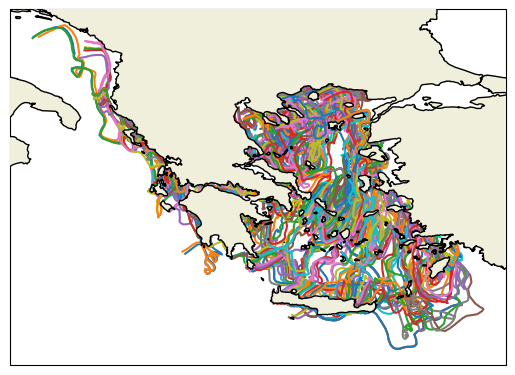

In [14]:
# Plot the trajectories
ds = xr.open_zarr('example_Greece_coast.zarr')

ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=19)
ax.coastlines(zorder=20)
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())

plt.show()